# Numerical stability

<!--
<img src="aps_lesch_cal.png"/>
-->
## Stefan's example

$$
\frac{\partial U}{\partial t} = \nu^* \frac{\partial^2 U}{\partial z^2} 
$$

If boundary conditions do not vary, a steady-state solution will eventually be reached (Ferziger 2001, p.144).

#### Explicit discretization at node $i$:

$$
\frac{U_i^{(n+1)} - U_i^{(n)}}{\Delta t} = \nu^* \frac{U_{i-1}^{(n)} - 2 U_{i}^{(n)} + U_{i+1}^{(n)}}{\Delta z^2} 
$$

$$
\Rightarrow U_i^{(n+1)}  = \underbrace{\frac{\nu^* \Delta t}{\Delta z^2}}_d  \left(U_{i-1}^{(n)} - 2 U_{i}^{(n)} + U_{i+1}^{(n)}\right) + U_i^{(n)}
$$


$$
\begin{bmatrix} \vdots \\ U_i^{(n+1)} \\ \vdots   \end{bmatrix} = \begin{bmatrix} \ddots  & & &  \\ & d & 1 - 2d & d &  \\ & & & \ddots   \end{bmatrix} \begin{bmatrix} \vdots \\ U_i^{(n)} \\ \vdots   \end{bmatrix}
$$

$$
x^{(n+1)} = A x^{(n)}
$$

- If we disregard the two boundaries, then $A$ is a symmetric matrix. This means that it has real eigenvalues and that the eignevectors are orthogonal.
- To converge, the spectral radius, $r \equiv max(\lambda_i)$ should be less than one (Ferziger 2001, p.144).
  - Hand-waving proof: The eigenvectors are orthogonal and can thus span the solution vector space. Hence, the initial guess is a linear combination of the eigenvectors: $x_0 = \sum_k c_k v_k$. Start of induction proof:
  
  $$
  x^{(1)} = A x^{(0)}  = A \sum_k c_k v_k = \sum_k c_k \lambda_k v_k
  $$
  
  $$
  x^{(2)} = A x^{(1)}  = A \sum_k c_k \lambda_k v_k  = \sum_k c_k (\lambda_k)^2 v_k
  $$
  
     It is clear, that the power of the eigenvalues increase, which is the reason for the $r < 1$ convergence criterium. **But if r is smaller than one, will the solution then not go to 0?**
   - Hand-waving proof 2 (like Ferziger p.97): Define the iteration error $\epsilon^{(n)} \equiv x^{(con)} - x^{(n)}$ and use that the converged solution satisfy $x^{(con)} = A x^{(con)}$ :
   
  $$
  \begin{align}
  \epsilon^{(n+1)} &= x^{(con)} - x^{(n+1)} \\
                   &= x^{(con)} - A x^{(n)} \\
                   &= A x^{(con)} - A x^{(n)} \\
                   &= A \epsilon^{(n)} \\
  \end{align}
  $$
  
     Now use the same argumentation as in the other proof, i.e. that $\epsilon^{(0)}$ can be written as a linear combination of the eigenvectors and that we must have $r < 1$ for $\epsilon^{(n+1)} \rightarrow 0$.
  
- From physical considerations, $d > 0$.
- When $d >\approx 0.54$, then the spectral radius is larger than 1 $\rightarrow$ no convergence.
 




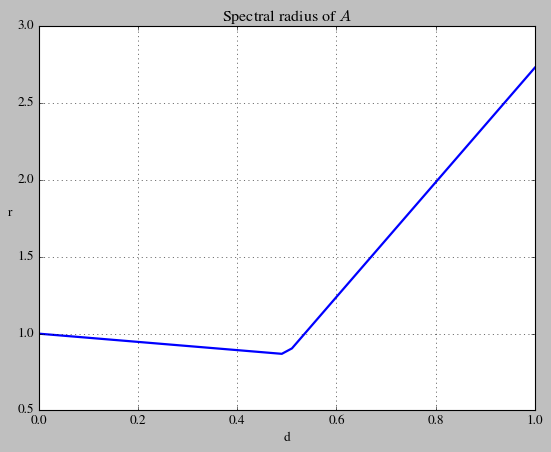

In [68]:
import numpy as np
import xarray
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
from mchba.lib import tridiag


# PLOT STYLE ##################################
mpl.style.use('classic')
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.numpoints"] = 1
plt.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid']=True
yd = dict(rotation=0, ha='right')
plt.close('all')

N = 5
# Ferziger p.145 writes that we shoud require d < 0.5

def create_trimatrix(d):
    a1 = np.ones(N-1)*d
    a2 = np.ones(N)*(1-2*d)
    a3 = np.ones(N-1)*d
    A = tridiag(a1,a2,a3)
    w, V = np.linalg.eig(A)
    r = np.max(np.abs(w))
    
    return A, w, r 

#A, w, r = create_trimatrix(0.6)
#print(A)
#print(w)
#print(r)

dvec = np.linspace(0,1,50)
rvec = np.zeros(len(dvec))
for i in range(len(dvec)):
    A, w, r = create_trimatrix(dvec[i])
    rvec[i] = r


fig = plt.figure()
plt.title('Spectral radius of $A$')
plt.plot(dvec,rvec)
plt.xlabel('d')
plt.ylabel('r',yd);
    

#### Implicit discretization at node $i$:

$$
\frac{U_i^{(n+1)} - U_i^{(n)}}{\Delta t} = \nu^* \frac{U_{i-1}^{(n+1)} - 2 U_{i}^{(n+1)} + U_{i+1}^{(n+1)}}{\Delta z^2} 
$$

$$
\Rightarrow U_i^{(n+1)} - \underbrace{\frac{\nu^* \Delta t}{\Delta z^2}}_d  \left(U_{i-1}^{(n+1)} - 2 U_{i}^{(n+1)} + U_{i+1}^{(n+1)}\right) =  U_i^{(n)}
$$


$$
  \begin{bmatrix} \ddots  & & &  \\ & - d & 1 + 2 d & - d &  \\ & & & \ddots   \end{bmatrix} \begin{bmatrix} \vdots \\ U_i^{(n+1)} \\ \vdots   \end{bmatrix} = \begin{bmatrix} \vdots \\ U_i^{(n)} \\ \vdots   \end{bmatrix}
$$

$$
A x^{(n+1)}  = x^{(n)}
$$

We need to find $A^{-1}$ to advance to the next timestep! This is only possible if $A$ is non-singular. 
- $A$ is guarenteed to be non-singular, if it is diagonally-dominant:
  $$
  |a_{\alpha \alpha}| > \sum_{\alpha \neq \beta} |a_{\alpha \beta}|
  $$
  
  That is, the absolute diagonal element, should be larger than the sum of the other absolute row elements (nice explanation and examples here: https://en.wikipedia.org/wiki/Diagonally_dominant_matrix).
- Diagonal dominance is in CFD language called "Scarbourough condition" and ensures convergence.
- Another way to assess if $A$ is non-singular: The determinant should be non-zero. For real, symmetric matrices, we can calculate $\text{det}(A)=\sum_i \lambda_i$ .
- When we then are assured that $A$ is non-singular (so we can solve the equation), then we can use the spectral radius argument again, but now we need the eigenvalues of $A^{-1}$. Lemma:

           The eigenvalues of inv(A) is just the inverse of A's eigenvalues
  Hence, it is desirable if the eigenvalues of $A$ are *large*. In fact, we must have than all eigenvalues of $A$ are larger than one, if the spectral radius of $A^{-1}$ should be less than one.
  
- It looks like there is no upper limit of $d$ from the example below!

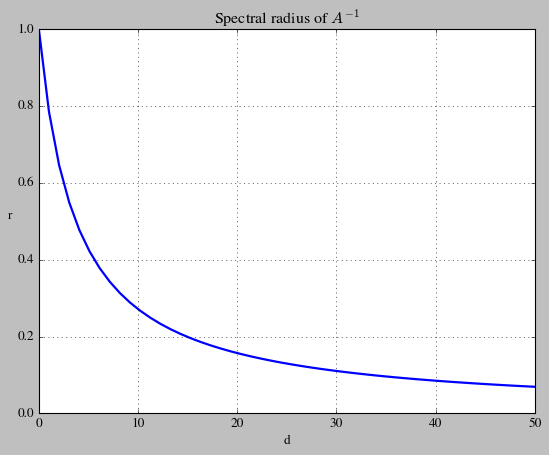

In [65]:
 
def create_trimatrix_imp(d):
    a1 = np.ones(N-1)*(-d)
    a2 = np.ones(N)*(1+2*d)
    a3 = np.ones(N-1)*(-d)
    A = tridiag(a1,a2,a3)
    w, V = np.linalg.eig(A)
    winv = 1/w
    r = np.max(np.abs(winv))
    
    return A, winv, r 

#A, w, r = create_trimatrix_imp(0.6)
#print(A)
#print(w)
#print(r)

dvec = np.linspace(0,50,50)
rvec = np.zeros(len(dvec))
for i in range(len(dvec)):
    A, w, r = create_trimatrix_imp(dvec[i])
    rvec[i] = r


fig = plt.figure()
plt.title('Spectral radius of $A^{-1}$')
plt.plot(dvec,rvec)
plt.xlabel('d')
plt.ylabel('r',yd);

#### Mixed implicit/explicit discretization at node $i$:

Imagine we discretize, such that we obtain:

$$
M x^{(n+1)}  = N x^{(n)}
$$

Ferziger (2001) p.97-99 then states that the spectral radius of $M^{-1} N$ should be less than one.


### Diffusion + extra anisotropy source term

$$
\begin{align}
\frac{\partial U}{\partial t} &= \nu^* \frac{\partial^2 U}{\partial z^2} - \frac{\partial k a_{1j}^{(ex)}}{\partial x_j} \\
&= \nu^* \frac{\partial^2 U}{\partial z^2} - \frac{\partial k a_{11}^{(ex)}}{\partial x_1} - \frac{\partial k a_{13}^{(ex)}}{\partial x_3}
\end{align}
$$

, where $a_{ij}^{(ex)} = \beta_4 (S \Omega - \Omega S)$ in 2D flows (Wallin 2000, app A). The strain and mean rotation tensors are (assuming no variation in $y$-direction, we are in the $x$-$z$ plane):

$$
S_{ij} = \begin{bmatrix} S_{11} & S_{12} & S_{13} \\ S_{12} & 0 & S_{23} \\ S_{13} & S_{23} & -S_{11} \end{bmatrix}  \quad , \quad
\Omega_{ij} = \begin{bmatrix} 0 & \Omega_{12} & \Omega_{13} \\ -\Omega_{12} & 0 & \Omega_{23} \\ -\Omega_{13} & -\Omega_{23} & 0 \end{bmatrix}
$$

Hence,

$$
\begin{align}
\left(S \Omega - \Omega S\right)_{11} &= -S_{12}\Omega_{12} -S_{13}\Omega_{13} - \left(\Omega_{12} S_{12} + \Omega_{13} S_{13} \right) = -2 \left(S_{12}\Omega_{12} + S_{13}\Omega_{13}\right)
\end{align}
$$

$$
\begin{align}
\left(S \Omega - \Omega S\right)_{13} &= S_{11}\Omega_{13} + S_{12}\Omega_{23} - \left(\Omega_{12} S_{23} - \Omega_{13} S_{11}  \right) = 2 S_{11}\Omega_{13} + S_{12}\Omega_{23} - \Omega_{12} S_{23} 
\end{align}
$$


How does this only add to non-diagonal?


